# Competition Objective is to detect fraud in transactions; 

## Data


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Transaction variables**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**


# 1. Importation and memory reduction
## 1.1. Importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go

import plotly.express as px
import plotly.tools as tls
from plotly.subplots import make_subplots

from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff


# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
import time

In [0]:
### Import data from google drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link1 = 'https://drive.google.com/open?id=1-2YM1zPLC6L4e94c7UHtfm70-UhrJAx9'
link2 = 'https://drive.google.com/open?id=1-8b83OZ7qoWypGqquhyXXmbETyhjDq0G'

link5 = 'https://drive.google.com/open?id=1v5in81M0aYl-pX5u-8Tq4G8kwFp4CVez'
_, id1 = link1.split('=')
_, id2 = link2.split('=')

_, id5 = link5.split('=')

downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('df_train.pkl')  
downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('df_test.pkl')  

downloaded5 = drive.CreateFile({'id':id5}) 
downloaded5.GetContentFile('sample_submission.csv')

## 1.2. Importing train datasets

In [0]:
df_train = pd.read_pickle("df_train.pkl")
df_test = pd.read_pickle("df_test.pkl")
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
print(df_train.shape)
print(df_test.shape)

(590540, 430)
(506691, 429)


## 1.3. Memory reduction

In [0]:
def resumetable(df):
    n = df.shape[0]
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values  
    summary['Missing %'] = round(summary['Missing'] / n * 100,2)
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values


    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True, object_tranform = False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    print('Lower bounded value: {:.2f}'.format(lower))
    print('Upper bounded value: {:.2f}'.format(upper))
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

To see the output of the Resume Table, click to see the output 

# 2. Preprocessing

In [6]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,...,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_merge,dist1_na,dist2_na,_Weekdays,_Hours,_Days
0,2987000,0,86400,4.226562,W,13926,-inf,150,discover,142,credit,315,87,19.0,0.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666504,13.0,...,0.0,0.0,0.0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,-480.0,New,NotFound,166.0,542.0,144.0,Miss,New,NotFound,Android,Samsung,32.0,2220x1080,match_status:2,T,F,T,T,mobile,Others,both,False,True,5,0,2
1,2987001,0,86401,3.367188,W,2755,404,150,mastercard,102,credit,325,87,8.0,0.0,gmail.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,...,0.0,0.0,0.0,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,621.0,500.0,Miss,New,NotFound,iOS,Safari,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,both,True,True,5,0,2
2,2987002,0,86469,4.078125,W,4663,490,150,visa,166,debit,330,87,287.0,0.0,outlook.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,37.875,0.666504,0.0,...,0.0,0.0,0.0,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,121.0,410.0,142.0,Miss,Found,Found,Miss,Chrome,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows,both,False,True,5,0,2
3,2987003,0,86499,3.912109,W,18132,567,150,mastercard,117,debit,476,87,8.0,0.0,yahoo.com,Maybe_P,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,0.0,37.875,0.666504,84.0,...,0.0,0.0,0.0,-5.0,221832.0,0.0,0.0,0.0,-6.0,0.0,0.0,100.0,NotFound,52.0,-300.0,New,NotFound,225.0,176.0,507.0,Miss,New,NotFound,Miss,Chrome,24.0,1920x1080,match_status:2,F,F,T,T,desktop,Windows,both,True,True,5,0,2
4,2987004,0,86506,3.912109,H,4497,514,150,mastercard,102,credit,420,87,8.0,0.0,gmail.com,Maybe_P,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,0.0,37.875,0.666504,15.0,...,0.0,0.0,0.0,0.0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,529.0,575.0,Miss,Found,Found,Mac,Chrome,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,both,True,True,5,0,2


In [0]:
df_train.drop(['_merge'], axis='columns', inplace=True)
df_test.drop(['_merge'], axis='columns', inplace=True)

In [0]:
categorical_features = []
for col in df_train.columns.drop('isFraud') :
    if df_train[col].dtype == 'object' or df_test[col].dtype=='object':
        categorical_features.append(col)


In [9]:
categorical_resume = resumetable(df_train[categorical_features])
categorical_resume

Dataset Shape: (590540, 36)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD,object,0,0.0,5,W,W,W
1,card1,object,0,0.0,13553,13926,2755,4663
2,card2,object,0,0.0,501,-inf,404,490
3,card3,object,0,0.0,115,150,150,150
4,card4,object,0,0.0,5,discover,mastercard,visa
5,card5,object,0,0.0,120,142,102,166
6,card6,object,0,0.0,5,credit,credit,debit
7,addr1,object,0,0.0,333,315,325,330
8,addr2,object,0,0.0,75,87,87,87
9,P_emaildomain,object,0,0.0,31,gmail.com,gmail.com,outlook.com


#### **Label Encoding :**

In [0]:
# Label Encoding

categorical_features_v2 = categorical_features.copy() #création d'une liste categorical_features_v2 pour le one-hot encoding
for f in categorical_features:
    if float(categorical_resume.loc[categorical_resume['Name']==f, 'Uniques']) > 8 : #pour les categorical_features donc le nombre de classe est > 8 nous faisons du label encoding 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))  
        categorical_features_v2.remove(f) #suppresion des categorical_features dont on a fait le label encoding


In [11]:
categorical_resume_v2 = resumetable(df_train[categorical_features_v2]) 
categorical_resume_v2


Dataset Shape: (590540, 26)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD,object,0,0.0,5,W,W,W
1,card4,object,0,0.0,5,discover,mastercard,visa
2,card6,object,0,0.0,5,credit,credit,debit
3,M1,object,0,0.0,3,T,Miss,T
4,M2,object,0,0.0,3,T,Miss,T
5,M3,object,0,0.0,3,T,Miss,T
6,M4,object,0,0.0,4,M2,M0,M0
7,M5,object,0,0.0,3,F,T,F
8,M6,object,0,0.0,3,T,T,F
9,M7,object,0,0.0,3,Miss,Miss,F


####**One hot encoding :**

In [12]:
# One hot encoding

merged_train_test = pd.concat([df_train[categorical_features_v2], df_test[categorical_features_v2]], axis =0, ignore_index=True) #création d'un seul dataframe pour simplifier le one-hot

#On effectue le one-hot encoding sur categorical_features_v2 (celle qui n'ont pas subit le label encoding)
for col in merged_train_test.columns :
    encoder = preprocessing.OneHotEncoder(sparse=False) # création de l'instance du one-hot encoder
    a = pd.DataFrame(encoder.fit_transform(merged_train_test[[col]].astype(np.str))) #création des colonnes correspond au nombre de classe
    a.columns = encoder.get_feature_names([col]) #nommé les colonnes par rapport au nom de classe correspond
    merged_train_test.drop(col ,axis=1, inplace=True)
    merged_train_test= pd.concat([merged_train_test, a ], axis=1)
resumetable(merged_train_test)


Dataset Shape: (1097231, 89)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value
0,ProductCD_C,float64,0,0.0,2,0.0,0.0,0.0
1,ProductCD_H,float64,0,0.0,2,0.0,0.0,0.0
2,ProductCD_R,float64,0,0.0,2,0.0,0.0,0.0
3,ProductCD_S,float64,0,0.0,2,0.0,0.0,0.0
4,ProductCD_W,float64,0,0.0,2,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
84,DeviceInfo_MacOS,float64,0,0.0,2,0.0,0.0,0.0
85,DeviceInfo_Others,float64,0,0.0,2,1.0,0.0,0.0
86,DeviceInfo_Trident/7.0,float64,0,0.0,2,0.0,0.0,0.0
87,DeviceInfo_Windows,float64,0,0.0,2,0.0,0.0,1.0


In [0]:
df_train.drop(categorical_features_v2, axis =1, inplace = True) # suppression des colonnes qui ont subit le one-hot encoding
df_test.drop(categorical_features_v2, axis =1, inplace = True) # suppression des colonnes qui ont subit le one-hot encoding
df_train = pd.concat([df_train, merged_train_test[0:len(df_train)]], axis = 1, ignore_index=False) # on ajoute le resultat du one hot a notre dataframe df_train
df_test = pd.concat([df_test, merged_train_test[len(df_train):].reset_index(drop= True)], axis = 1, ignore_index=False) # on ajoute le resultat du one hot a notre dataframe df_test


In [14]:
print(df_train.shape)
print(df_test.shape)

(590540, 492)
(506691, 491)


In [15]:
df_train=reduce_mem_usage(df_train, verbose=True, object_tranform = False)
df_test=reduce_mem_usage(df_test, verbose=True, object_tranform = False)

Mem. usage decreased to 601.48 Mb (35.9% reduction)
Mem. usage decreased to 523.33 Mb (35.6% reduction)


#### **V-features:**

In [16]:
vfeatures = []
for i in df_train.columns:
    if 'V' in i:
        vfeatures.append(i)
len(vfeatures)

339

In [17]:
print(vfeatures)

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V1

#### **PCA V-features :**

In [0]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=10):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    df.drop(cols, axis=1, inplace=True)
    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [0]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA


,PCA_V_0,PCA_V_1,PCA_V_2,PCA_V_3,PCA_V_4,PCA_V_5,PCA_V_6,PCA_V_7,PCA_V_8,PCA_V_9,PCA_V_10,PCA_V_11,PCA_V_12,PCA_V_13,PCA_V_14,PCA_V_15,PCA_V_16,PCA_V_17,PCA_V_18,PCA_V_19,PCA_V_20,PCA_V_21,PCA_V_22,PCA_V_23,PCA_V_24,PCA_V_25,PCA_V_26,PCA_V_27,PCA_V_28,PCA_V_29
0,-0.153477,-0.234965,-0.087372,-0.004832,0.056986,-0.058954,-0.006371,-0.044854,0.006245,-0.037562,-0.006179,-0.039167,-0.008556,0.000418,-0.035123,-0.025491,0.099918,-0.000949,0.017832,0.044673,0.026768,0.004023,0.010879,0.021593,0.031913,-0.006193,0.007768,0.016069,-0.026891,-0.025466
1,0.164787,-0.014400,0.027499,-0.334006,-0.108994,-0.023342,0.089121,-0.004151,-0.035853,-0.002951,-0.001366,0.046187,0.015678,-0.017441,-0.005605,-0.001102,0.020608,-0.007255,-0.007409,0.001689,-0.002543,0.002222,0.005758,0.009135,-0.016805,-0.004565,-0.000264,-0.001551,0.000943,-0.008022
2,-0.145220,-0.236204,-0.085772,0.016137,-0.046415,-0.005279,-0.014030,0.006788,-0.028609,-0.035786,-0.005683,-0.007171,0.001615,-0.015473,-0.002529,-0.001181,0.003105,-0.002174,-0.005238,-0.003257,0.002928,0.005600,0.003248,0.010721,0.003295,0.001209,-0.005682,-0.000765,0.010495,-0.008472
3,-0.148197,-0.243113,-0.090288,0.008653,-0.012343,0.077776,0.029918,-0.005872,0.002053,0.014049,-0.018579,0.000329,-0.088947,0.084000,0.106655,-0.060851,-0.007296,-0.020695,-0.010788,-0.017413,0.005133,0.033610,-0.007034,-0.012341,0.019809,0.033971,0.057537,-0.001686,0.006050,-0.009605
4,-0.099110,-0.598494,1.275604,0.289744,0.001767,-0.058603,0.070346,0.016769,-0.019807,-0.014905,-0.015026,-0.012464,0.006872,-0.006201,0.003117,-0.030022,-0.005065,0.016783,0.009546,-0.048355,0.014582,-0.115095,-0.034562,0.002965,0.053289,0.001489,0.036398,0.018091,-0.060369,0.055510


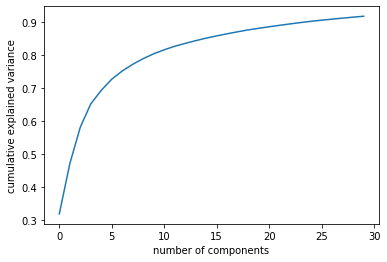

In [20]:
merged_train_test = pd.concat([df_train[vfeatures], df_test[vfeatures]], axis =0, ignore_index=True) #création d'un seul dataframe pour simplifier le one-hot
for col in vfeatures:
    merged_train_test[col] = (minmax_scale(merged_train_test[col], feature_range=(0,1)))

merged_train_test = PCA_change(merged_train_test, vfeatures, prefix='PCA_V_', n_components=30)
merged_train_test.head()

In [0]:
df_train.drop(vfeatures, axis = 1, inplace =True)
df_test.drop(vfeatures, axis = 1, inplace =True)

df_train = pd.concat([df_train, merged_train_test[0:len(df_train)]], axis = 1)
df_test = pd.concat([df_test, merged_train_test[len(df_train):].reset_index(drop= True)], axis = 1)

In [22]:
del merged_train_test
gc.collect()

2486

In [23]:
df_test.shape

(506691, 182)

In [24]:
df_train.shape

(590540, 183)

## 2.1 Outlier removing

In [0]:
TransactionAmt = df_train['TransactionAmt'].astype(np.float64)
Trans_mean, Trans_std = TransactionAmt.mean(), TransactionAmt.std()
lower_trans, upper_trans = Trans_mean - 3*Trans_std, Trans_mean+3*Trans_std

In [0]:
df_train = df_train[(TransactionAmt <upper_trans)& (TransactionAmt > lower_trans)]

In [0]:
Y_train = df_train['isFraud']
df_train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1, inplace = True)

In [0]:
df_test.drop(['TransactionID', 'TransactionDT'], axis = 1, inplace = True)

In [29]:
df_train.shape

(585222, 180)

## 2.2 Variance threshold

In [30]:
%%time
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=np.var(Y_train))

sel.fit(df_train)

CPU times: user 6.66 s, sys: 1.06 s, total: 7.72 s
Wall time: 7.77 s


In [0]:
df_train = df_train.iloc[:, sel.get_support()]
df_test = df_test.iloc[:, sel.get_support()]

In [32]:
df_train.shape

(585222, 123)

## 2.3. Multicolinearity



In [0]:
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [0]:
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    lm = LinearRegression()
    vifs = pd.Series(
        [1 / (1. - lm.fit(exog_df.loc[:, exog_df.columns != col].values, exog_df[col].values).score(exog_df.loc[:, exog_df.columns != col].values, exog_df[col].values)) 
        for col in exog_df.columns],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [0]:
for col in df_train.columns:
    if df_train[col].dtype == bool : 
        df_train[col] = df_train[col]*1
        df_test[col] = df_test[col]*1

In [36]:
%%time
res = variance_inflation_factors(df_train)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:425: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:425: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:425: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:594: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:425: RuntimeWarning:

invalid value enc

CPU times: user 48min 8s, sys: 4min 41s, total: 52min 49s
Wall time: 16min 5s


In [37]:
res[res>10]

addr2                 2.957032e+01
C9                    6.722115e+01
ProductCD_C           5.261254e+01
ProductCD_W           2.509950e+01
card4_mastercard      1.084408e+01
card4_visa            1.145424e+01
card6_credit          8.898633e+01
card6_debit           9.037987e+01
M1_Miss                        inf
M1_T                  5.821825e+03
M2_F                           inf
M2_Miss                        inf
M2_T                           inf
M3_F                           inf
M3_Miss                        inf
M3_T                           inf
M4_M0                          inf
M4_M1                          inf
M4_M2                          inf
M4_Miss                        inf
M5_F                           inf
M5_Miss                        inf
M5_T                           inf
M6_F                           inf
M6_Miss                        inf
M6_T                           inf
M7_F                           inf
M7_Miss                        inf
M7_T                

In [0]:
multicolinearity_var = list(res[res>10].index)

In [0]:
df_train.drop(multicolinearity_var, axis = 1, inplace = True)
df_test.drop(multicolinearity_var, axis = 1, inplace = True)

In [40]:
df_train.shape

(585222, 64)

## 2.4. Train validation split

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_train,
    Y_train,
    stratify = Y_train,
    test_size=0.3,
    random_state=10)
X_train.shape, X_val.shape

((409655, 64), (175567, 64))

# 3. Modeling

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification 

def model_res(model,X_train, X_val, y_train, y_val, test, title= ''):
  model.fit(X_train, y_train)
  pred_train = model.predict_proba(X_train)
  print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))
  pred_test = model.predict_proba(X_val)
  print("score auc test :",roc_auc_score(y_val, pred_test[:, 1]))
  predict=model.predict_proba(test)
  sample_submission['isFraud']=predict[:,1]
  sample_submission.to_csv(title+'.csv',index=False)

#LASSO

La méthode de lasso va nous permettre de mettre certaines features à 0 ce qui nous permettra de les enlever de notre modèles.

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression, SGDRegressor

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [45]:
%%time
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver ='saga',max_iter=10000))
sel_.fit(scaler.transform(X_train), y_train)

CPU times: user 26min 43s, sys: 281 ms, total: 26min 43s
Wall time: 26min 44s


In [46]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 64
selected features: 64
features with coefficients shrank to zero: 0


In [47]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index([], dtype='object')

In [48]:
X_train_selected = sel_.transform(X_train)
X_val_selected = sel_.transform(X_val)
X_train_selected.shape, X_val_selected.shape

((409655, 64), (175567, 64))

In [0]:
df_test_lasso = sel_.transform(df_test)

In [54]:
## Random Forest
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification 
rf = RandomForestClassifier(n_estimators = 50, random_state = 42)
model_res(rf, X_train_selected, X_val_selected, y_train, y_val, df_test_lasso, title='rf_lasso')

score auc train : 0.9999999933906375
score auc test : 0.9280740470153142
CPU times: user 1min 38s, sys: 94.8 ms, total: 1min 38s
Wall time: 1min 38s


In [63]:
## KNN 
%%time
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model_res(knn, X_train_selected, X_val_selected, y_train, y_val, df_test_lasso, title='knn_lasso')

score auc train : 0.9904853505255286
score auc test : 0.7655903021353637
CPU times: user 27min 52s, sys: 1.02 s, total: 27min 53s
Wall time: 27min 51s


# Elastic net

In [55]:
%%time
sel2_ = SelectFromModel(LogisticRegression(C=1, penalty = 'elasticnet', l1_ratio = 0.5, solver = 'saga', max_iter=10000))
sel2_.fit(scaler.transform(X_train), y_train)

CPU times: user 25min 37s, sys: 169 ms, total: 25min 37s
Wall time: 25min 37s


In [56]:
sel2_.get_support()

array([False, False, False, False, False, False, False, False, False,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True])

In [57]:
selected2_feat = X_train.columns[(sel2_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected2_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel2_.estimator_.coef_ == 0)))

total features: 64
selected features: 13
features with coefficients shrank to zero: 0


In [58]:
removed2_feats = X_train.columns[(sel2_.estimator_.coef_ == 0).ravel().tolist()]
removed2_feats

Index([], dtype='object')

In [59]:
X_train_selected2 = sel2_.transform(X_train)
X_val_selected2 = sel2_.transform(X_val)
X_train_selected2.shape, X_val_selected2.shape

((409655, 13), (175567, 13))

In [0]:
df_test_elnet = sel2_.transform(df_test)

In [61]:
## Random forest :
%%time
model_res(rf, X_train_selected2, X_val_selected2, y_train, y_val, df_test_elnet, title='rf_elnet')

score auc train : 0.9808604866709494
score auc test : 0.8951284953752436
CPU times: user 53.2 s, sys: 99.3 ms, total: 53.3 s
Wall time: 53.3 s


In [64]:
## KNN :
%%time
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
model_res(knn, X_train_selected2, X_val_selected2, y_train, y_val, df_test_elnet, title='knn_elnet')

score auc train : 0.9241905559497615
score auc test : 0.8121833528217052
CPU times: user 10min 51s, sys: 321 ms, total: 10min 52s
Wall time: 10min 51s
